# Projet d'Analyse Hydro-Océanographique 
### Etude de cas: Carte nautique entre Casablanca et Rabat 

## 1. Préparation de l'environnement

In [34]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# Pour le réseau bayésien
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator

# Pour le clustering hiérarchique
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Pour le Deep Learning
import tensorflow as tf

sns.set(style='whitegrid', rc={'figure.figsize':(10,6)})
plt.rcParams['figure.figsize'] = (12, 8)

RAW_DIR       = os.path.join('..', 'data', 'raw')
PROCESSED_DIR = os.path.join('..', 'data', 'processed')
os.makedirs(PROCESSED_DIR, exist_ok=True)


## 2. Chargement des données brutes

Fichiers raw : ['cdsWind.nc', 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1748321230089.nc', 'gebco_2024.nc']
<xarray.Dataset>
Dimensions:     (valid_time: 744, latitude: 3, longitude: 5)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2024-05-01 ... 2024-05-31T23:00:00
  * latitude    (latitude) float64 34.0 33.75 33.5
  * longitude   (longitude) float64 -7.5 -7.25 -7.0 -6.75 -6.5
    expver      (valid_time) object ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 ...
    v10         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-27T18:11 GRIB to CDM+CF via cfgrib-0.9.1...
<xarray.Dataset>
Dimensions:    (time: 17544, dep

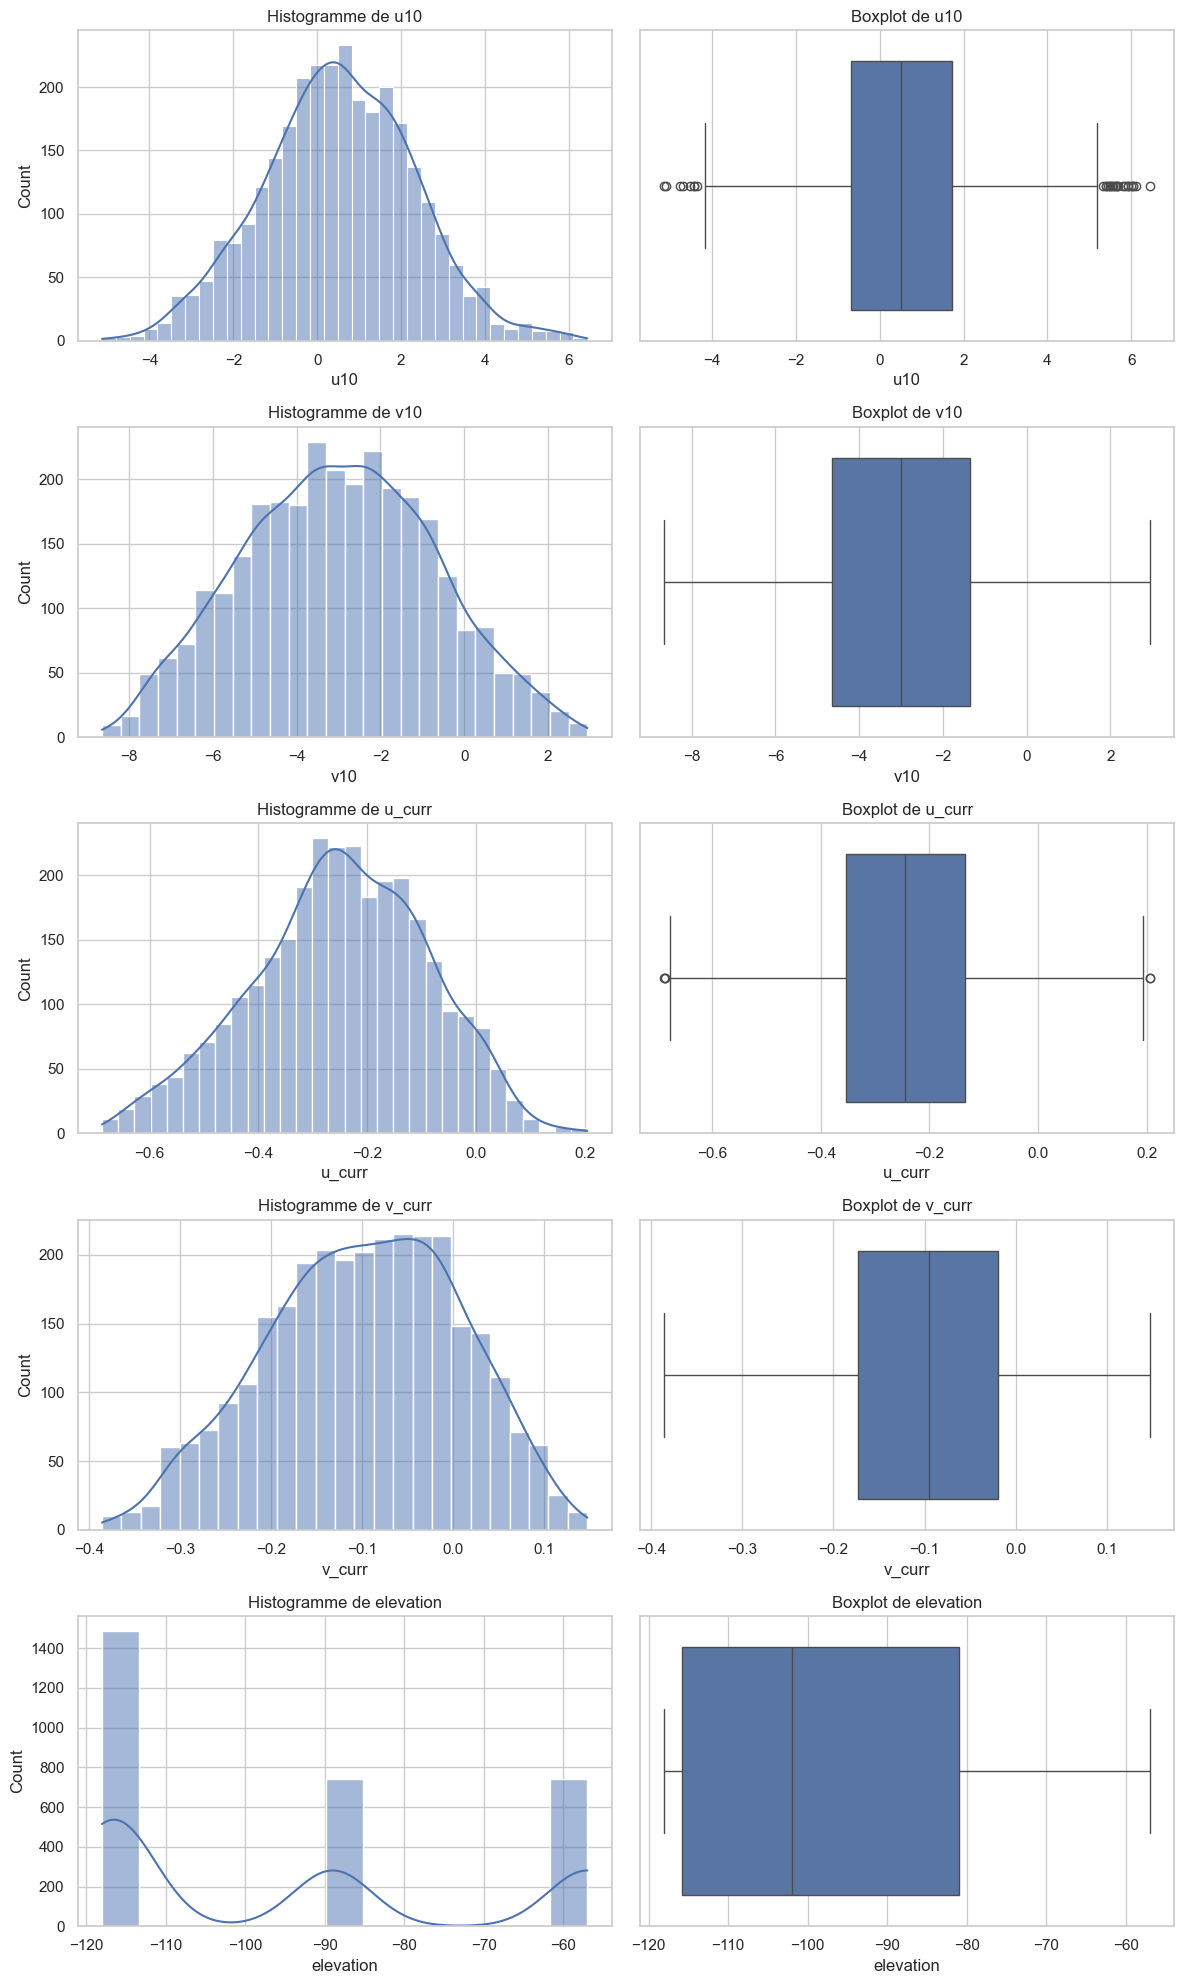


Matrice de corrélation :
                 u10       v10    u_curr    v_curr  elevation
u10        1.000000  0.271535  0.311682 -0.103562  -0.041195
v10        0.271535  1.000000  0.440236  0.465328   0.115075
u_curr     0.311682  0.440236  1.000000  0.203188   0.555859
v_curr    -0.103562  0.465328  0.203188  1.000000   0.095804
elevation -0.041195  0.115075  0.555859  0.095804   1.000000


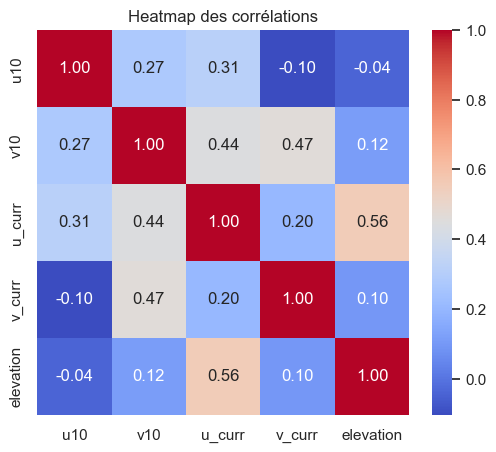

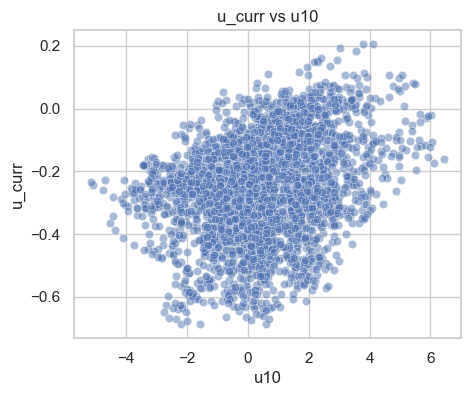

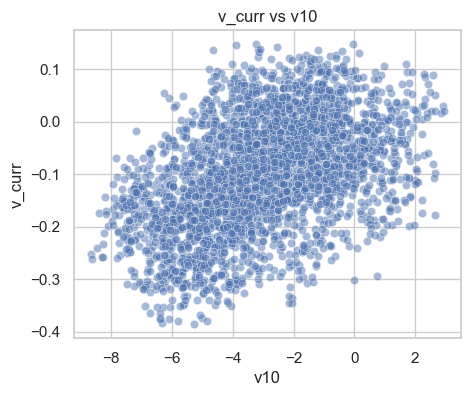

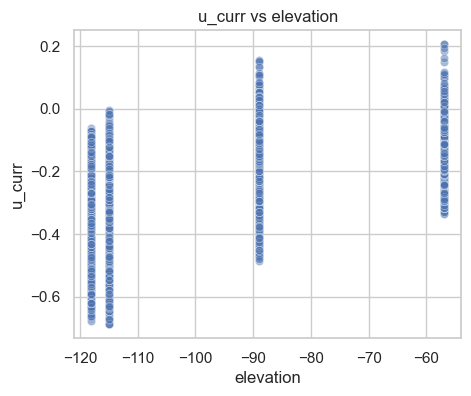

In [35]:
# Liste des fichiers pour vérifier
print("Fichiers raw :", os.listdir(RAW_DIR))

wind       = xr.open_dataset(os.path.join(RAW_DIR, 'cdsWind.nc'))
currents   = xr.open_dataset(os.path.join(RAW_DIR, 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1748321230089.nc'))
bathymetry = xr.open_dataset(os.path.join(RAW_DIR, 'gebco_2024.nc'))

print(wind)
print(currents)
print(bathymetry)

# Analyse descriptive complète
# 2.1 Statistiques univariées
print("Statistiques descriptives :\n", df[['u10','v10','u_curr','v_curr','elevation']].describe())

# 2.2 Histogrammes et boxplots
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
vars_ = ['u10','v10','u_curr','v_curr','elevation']

for i, col in enumerate(vars_):
    sns.histplot(df[col], ax=axes[i,0], kde=True)
    axes[i,0].set_title(f"Histogramme de {col}")
    
    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

# 2.3 Matrice de corrélation
corr = df[['u10','v10','u_curr','v_curr','elevation']].corr()
print("\nMatrice de corrélation :\n", corr)

# 2.4 Heatmap de corrélation
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap des corrélations")
plt.show()

# 2.5 Scatter plots clés
pairs = [('u10','u_curr'), ('v10','v_curr'), ('elevation','u_curr')]
for x,y in pairs:
    plt.figure(figsize=(5,4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(f"{y} vs {x}")
    plt.show()

## 3. Conversion & Fusion des données (interpolation)

In [36]:
# 3. Conversion & Fusion des données (interpolation)

# 3.1 Sélection de la couche surface des courants
currents_surf = currents.sel(depth=currents.depth.min())

# 3.2 Interpolation des courants sur la grille du vent
curr2wind = currents_surf.interp(
    time=wind.valid_time,
    latitude=wind.latitude,
    longitude=wind.longitude,
    method="nearest"  # ou "linear"
)

# 3.3 Interpolation de la bathymétrie sur la grille du vent
bath2wind = bathymetry.interp(
    lat=wind.latitude,
    lon=wind.longitude,
    method="nearest"
)

# 3.4 Construction d’un Dataset xarray fusionné
ds = xr.Dataset({
    'u10':     (wind.u10.dims,      wind.u10.data),
    'v10':     (wind.v10.dims,      wind.v10.data),
    'u_curr':  (curr2wind.uo.dims,  curr2wind.uo.data),
    'v_curr':  (curr2wind.vo.dims,  curr2wind.vo.data),
    'elevation': (bath2wind.elevation.dims, bath2wind.elevation.data),
}, coords={
    'time':      wind.valid_time,
    'latitude':  wind.latitude,
    'longitude': wind.longitude
})

# 3.5 Conversion en DataFrame pandas
df = ds.to_dataframe().reset_index()

# 3.6 Vérification
print("Shape après interpolation & fusion :", df.shape)
print(df.head())
## 3.7 Nettoyage et préparation (version corrigée)

# 1) Renommer valid_time en time_wind pour lever l’ambiguïté
df = df.rename(columns={'valid_time':'time_wind'})

# 2) Supprimer la colonne 'time' héritée (si elle provient des courants/bathymétrie et n'est pas la même que time_wind)
if 'time' in df.columns and 'time_wind' in df.columns:
    df = df.drop(columns=['time'])

# 3) Supprimer les colonnes inutiles
df = df.drop(columns=['number','expver'])

# 4) Supprimer les lignes où il manque des données critiques
df = df.dropna(subset=['u_curr','v_curr','elevation'])

# 5) Renommer time_wind en time si tu préfères un nom unique
df = df.rename(columns={'time_wind':'time'})

print("Shape après nettoyage :", df.shape)
print(df.head())




Shape après interpolation & fusion : (11160, 11)
  valid_time  latitude  longitude       u10       v10    u_curr    v_curr  \
0 2024-05-01      34.0      -7.50  2.071823 -0.967117 -0.295898 -0.106445   
1 2024-05-01      34.0      -7.25  1.301315  0.447922 -0.176758 -0.047852   
2 2024-05-01      34.0      -7.00  0.612839  1.170578 -0.102539 -0.037109   
3 2024-05-01      34.0      -6.75  0.039597  1.653000       NaN       NaN   
4 2024-05-01      34.0      -6.50 -0.177200  2.098312       NaN       NaN   

   elevation  number expver       time  
0     -118.0       0   0001 2024-05-01  
1     -115.0       0   0001 2024-05-01  
2      -89.0       0   0001 2024-05-01  
3      108.0       0   0001 2024-05-01  
4      198.0       0   0001 2024-05-01  
Shape après nettoyage : (2976, 8)
                  time  latitude  longitude       u10       v10    u_curr  \
0  2024-05-01 00:00:00     34.00      -7.50  2.071823 -0.967117 -0.295898   
1  2024-05-01 00:00:00     34.00      -7.25  1.301315 

## 4. Réseau bayésien

In [37]:
# 4.1 Colonnes à discrétiser
disc_cols = ['u10','v10','u_curr','v_curr','elevation']
disc_df = df[disc_cols].copy()

# 4.2 Discrétisation en 5 bins
for col in disc_cols:
    disc_df[col] = pd.cut(disc_df[col], bins=5, labels=False)

# 4.3 Vérification
print("Aperçu disc_df :")
print(disc_df.head())


Aperçu disc_df :
    u10  v10  u_curr  v_curr  elevation
0     3    3       2       2          0
1     2    3       2       3          0
2     2    4       3       3          2
5     2    3       3       2          4
15    3    3       2       2          0


## 5. Apprentissage du réseau bayésien

In [38]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator

# 5.1 Structure learning sur le DataFrame discretisé
hc = HillClimbSearch(disc_df)
best_struct = hc.estimate(scoring_method=BicScore(disc_df))

# 5.2 Instanciation et apprentissage du modèle
bn = BayesianNetwork(best_struct.edges())
bn.fit(disc_df, estimator=BayesianEstimator, prior_type='BDeu')

# 5.3 Affichage des arêtes apprises
print("Arêtes apprises du réseau bayésien :", bn.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

Arêtes apprises du réseau bayésien : [('u10', 'u_curr'), ('v10', 'u10'), ('v_curr', 'v10'), ('elevation', 'u_curr'), ('elevation', 'v_curr'), ('elevation', 'v10')]


## 6. Clustering Ascendant Hiérarchique (CAH)

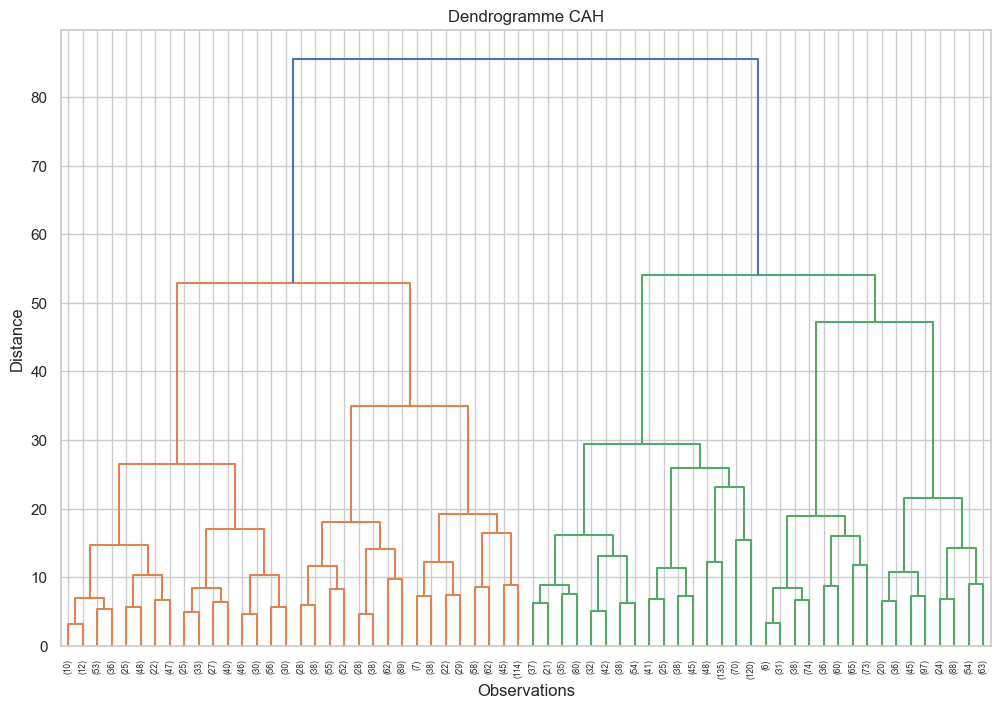

Répartition des clusters :
cluster
3    861
4    810
2    765
1    540
Name: count, dtype: int64

Centres moyens par cluster :
              u10       v10    u_curr    v_curr   elevation
cluster                                                    
1       -0.360338 -3.764459 -0.162656 -0.090026  -57.000000
2        1.245907 -0.758586 -0.103489 -0.036918  -87.081046
3       -0.210075 -3.098937 -0.372137 -0.049496 -111.145180
4        1.154823 -4.462048 -0.315818 -0.214580 -109.732099


In [39]:
# 6 : Clustering Ascendant Hiérarchique (CAH)
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler

# 6.1 Normalisation des mêmes variables discrétisées ou continues
features = ['u10','v10','u_curr','v_curr','elevation']
X_scaled = StandardScaler().fit_transform(df[features])

# 6.2 Construction et affichage du dendrogramme
Z = linkage(X_scaled, method='ward')
plt.figure()
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Dendrogramme CAH")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()

# 6.3 Découpage en clusters
k = 4  # ajuste selon le découpage souhaité sur le dendrogramme
df['cluster'] = fcluster(Z, k, criterion='maxclust')

# 6.4 Inspection de la répartition
print("Répartition des clusters :")
print(df['cluster'].value_counts())
print("\nCentres moyens par cluster :")
print(df.groupby('cluster')[features].mean())


## 7.  Deep Learning

Epoch 1/50


C:\Users\zaineb\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5307 - loss: 3.1822

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5313 - loss: 3.1569 - val_accuracy: 0.8908 - val_loss: 0.4248
Epoch 2/50
35/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6306 - loss: 1.2266 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6515 - loss: 1.0708 - val_accuracy: 0.9055 - val_loss: 0.3339
Epoch 3/50
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.3470 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8771 - loss: 0.3388 - val_accuracy: 0.9433 - val_loss: 0.2653
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8849 - loss: 0.2945 - val_accuracy: 0.9328 - val_loss: 0.2334
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9107 - loss: 0.2469

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9107 - loss: 0.2469 - val_accuracy: 0.9601 - val_loss: 0.1915
Epoch 6/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9149 - loss: 0.2242

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9150 - loss: 0.2240 - val_accuracy: 0.9643 - val_loss: 0.1666
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9341 - loss: 0.1891 - val_accuracy: 0.9517 - val_loss: 0.1574
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9400 - loss: 0.1734 - val_accuracy: 0.9202 - val_loss: 0.1733
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9454 - loss: 0.1615 - val_accuracy: 0.9580 - val_loss: 0.1361
Epoch 10/50
35/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9492 - loss: 0.1440 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9520 - loss: 0.1436 - val_accuracy: 0.9748 - val_loss: 0.1193
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9583 - loss: 0.1324 - val_accuracy: 0.9748 - val_loss: 0.1084
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9615 - loss: 0.1197 - val_accuracy: 0.9517 - val_loss: 0.1134
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9580 - loss: 0.1177 - val_accuracy: 0.9517 - val_loss: 0.1115
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9541 - loss: 0.1139 - val_accuracy: 0.9538 - val_loss: 0.1104
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9460 - loss: 0.1303 - val_accuracy: 0.9580 - val_loss: 0.0951
Epoch 16/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9613 - loss: 0.1110 - val_accuracy: 0.9706 - val_loss: 0.0809
Epoch 17/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9661 - loss: 0.0998 - val_accuracy: 0.9391 - val_loss: 0.1

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9560 - loss: 0.1026 - val_accuracy: 0.9769 - val_loss: 0.0741
Epoch 19/50
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9638 - loss: 0.0988 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9596 - loss: 0.1075 - val_accuracy: 0.9790 - val_loss: 0.0782
Epoch 20/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9670 - loss: 0.0923 - val_accuracy: 0.9790 - val_loss: 0.0683
Epoch 21/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9697 - loss: 0.0850 - val_accuracy: 0.9664 - val_loss: 0.0787
Epoch 22/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9644 - loss: 0.0841 - val_accuracy: 0.9517 - val_loss: 0.0905
Epoch 23/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9653 - loss: 0.0797 - val_accuracy: 0.9706 - val_loss: 0.0728
Epoch 24/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9730 - loss: 0.0888 - val_accuracy: 0.9433 - val_loss: 0.1131
Epoch 25/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9359 - loss: 0.1340 - val_accuracy: 0.9790 - val_loss: 0.0623
Epoch 26/50
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9696 - loss: 0.0861 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9664 - loss: 0.0931 - val_accuracy: 0.9832 - val_loss: 0.0614
Epoch 27/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9691 - loss: 0.0781 - val_accuracy: 0.9223 - val_loss: 0.1571
Epoch 28/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9525 - loss: 0.1154 - val_accuracy: 0.9790 - val_loss: 0.0620
Epoch 29/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9770 - loss: 0.0686 - val_accuracy: 0.9727 - val_loss: 0.0664
Epoch 30/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9795 - loss: 0.0611 - val_accuracy: 0.9748 - val_loss: 0.0637
Epoch 31/50
40/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9696 - loss: 0.0733 

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9711 - loss: 0.0697 - val_accuracy: 0.9895 - val_loss: 0.0545
Epoch 32/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0773 - val_accuracy: 0.9790 - val_loss: 0.0586
Epoch 33/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9699 - loss: 0.0663 - val_accuracy: 0.9853 - val_loss: 0.0480
Epoch 34/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9776 - loss: 0.0598 - val_accuracy: 0.9706 - val_loss: 0.0624
Epoch 35/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9750 - loss: 0.0672 - val_accuracy: 0.9622 - val_loss: 0.0597
Epoch 36/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9652 - loss: 0.0661 - val_accuracy: 0.9874 - val_loss: 0.0496
Epoch 37/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9794 - loss: 0.0558 - val_accuracy: 0.9475 - val_loss: 0.1201
Epoch 38/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9741 - loss: 0.0754 - val_accuracy: 0.9580 - val_loss: 0.0

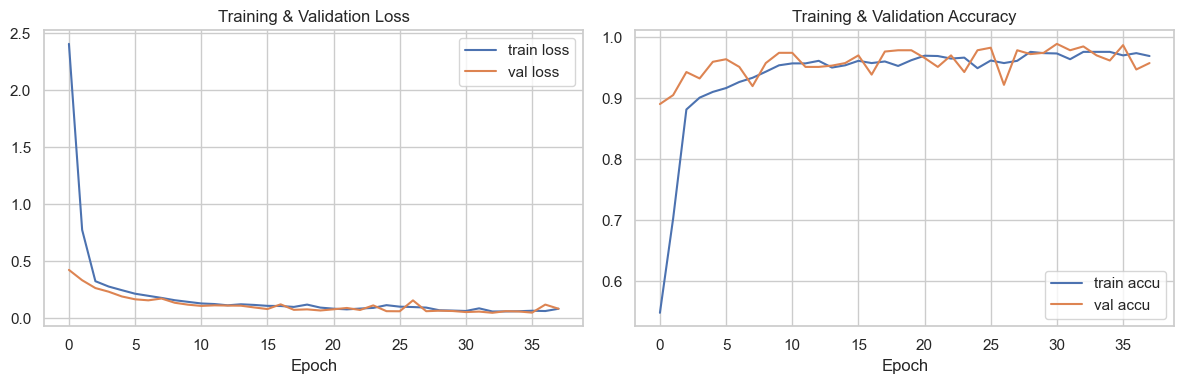

In [40]:
# 7. Modèle Deep Learning amélioré

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 7.1 Préparation X/y
features = ['u10','v10','u_curr','v_curr','elevation']
X = df[features].values
y = (df['u10'] > df['u10'].median()).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7.2 Définition du modèle
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 7.3 Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# 7.4 Entraînement
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 7.5 Évaluation
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"⚡️ Précision sur le test : {acc:.3f}")

# 7.6 Courbes d'entraînement
plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train accu')
plt.plot(history.history['val_accuracy'], label='val accu')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


## 8. Export du DataFrame et du modèle

In [41]:
# 8.1 Export du DataFrame
out_csv = os.path.join(PROCESSED_DIR, 'processed_data.csv')
df.to_csv(out_csv, index=False)
print("✔️ DataFrame exporté vers :", out_csv)

# 8.2 Sauvegarde du modèle (format Keras natif)
model_path = os.path.join(PROCESSED_DIR, 'best_model.keras')
model.save(model_path)
print("✔️ Modèle sauvegardé vers :", model_path)


✔️ DataFrame exporté vers : ..\data\processed\processed_data.csv
✔️ Modèle sauvegardé vers : ..\data\processed\best_model.keras
